In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime

In [2]:
conn = sqlite3.connect('C:/Users/akhil/Desktop/HAP 880/mmics/mimic.db')
df_adm = pd.read_sql("select * from ADMISSIONS ", conn)

In [3]:
# convert to dates
df_adm.ADMITTIME = pd.to_datetime(df_adm.ADMITTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_adm.DISCHTIME = pd.to_datetime(df_adm.DISCHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_adm.DEATHTIME = pd.to_datetime(df_adm.DEATHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

# check to see if there are any missing dates
print('Number of missing date admissions:', df_adm.ADMITTIME.isnull().sum())
print('Number of missing date discharges:', df_adm.DISCHTIME.isnull().sum())

Number of missing date admissions: 0
Number of missing date discharges: 0


In [4]:
# sort by subject_ID and admission date
df_adm = df_adm.sort_values(['SUBJECT_ID','ADMITTIME'])
df_adm = df_adm.reset_index(drop = True)
# add the next admission date and type for each subject using groupby
# we have to use groupby otherwise the dates will be from different subjects
df_adm['NEXT_ADMITTIME'] = df_adm.groupby('SUBJECT_ID').ADMITTIME.shift(-1)
# get the next admission type
df_adm['NEXT_ADMISSION_TYPE'] = df_adm.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)

# get rows where next admission is elective and replace with naT or nan
rows = df_adm.NEXT_ADMISSION_TYPE == 'ELECTIVE'
df_adm.loc[rows,'NEXT_ADMITTIME'] = pd.NaT
df_adm.loc[rows,'NEXT_ADMISSION_TYPE'] = np.NaN

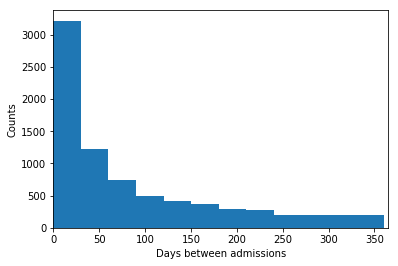

In [5]:
df_adm = df_adm.sort_values(['SUBJECT_ID','ADMITTIME'])

# back fill
df_adm[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']] = df_adm.groupby(['SUBJECT_ID'])[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']].fillna(method = 'bfill')


# calculating the number of days between discharge and next admission
df_adm['DAYS_NEXT_ADMIT']=  (df_adm.NEXT_ADMITTIME - df_adm.DISCHTIME).dt.total_seconds()/(24*60*60)

# plot a histogram of days between readmissions if they exist
plt.hist(df_adm.loc[~df_adm.DAYS_NEXT_ADMIT.isnull(),'DAYS_NEXT_ADMIT'], bins =range(0,365,30))
plt.xlim([0,365])
plt.xlabel('Days between admissions')
plt.ylabel('Counts')
plt.show()

In [6]:
print('Number with a readmission:', (~df_adm.DAYS_NEXT_ADMIT.isnull()).sum())
print('Total Number:', len(df_adm))

Number with a readmission: 11399
Total Number: 58976


In [7]:
dfnew = df_adm[['SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME','DAYS_NEXT_ADMIT','NEXT_ADMITTIME','ETHNICITY','ADMISSION_TYPE','DEATHTIME','DIAGNOSIS']]
dfnew['DEATHTIME'].notnull().value_counts()
dfnew = dfnew[dfnew['DEATHTIME'].isnull()]
dfnew['Readmssion'] = np.where(dfnew['DAYS_NEXT_ADMIT']<30, '1', '0')
data=dfnew[['SUBJECT_ID','HADM_ID','ADMITTIME','ADMISSION_TYPE','ETHNICITY','DIAGNOSIS','Readmssion']]

In [8]:
#Removing Newborn
data = data.loc[data.ADMISSION_TYPE != 'NEWBORN'].copy()
data['Readmssion'].value_counts()

0    42358
1     2963
Name: Readmssion, dtype: int64

In [9]:
# Compress the number of ethnicity categories
data['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
data['ETHNICITY'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
data['ETHNICITY'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
data['ETHNICITY'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
data['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER','UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN', inplace=True)
data['ETHNICITY'].loc[~data['ETHNICITY'].isin(data['ETHNICITY'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'
data['ETHNICITY'].value_counts()

C:\Users\akhil\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


WHITE                     32501
OTHER/UNKNOWN              5640
BLACK/AFRICAN AMERICAN     4471
HISPANIC/LATINO            1625
ASIAN                      1084
Name: ETHNICITY, dtype: int64

In [10]:
#Importing DIAGNOSIS_ICD table
df_daig =pd.read_sql("select * from DIAGNOSES_ICD ", conn)
print('There are {} unique ICD9 codes in this dataset.'.format(df_daig['ICD9_CODE'].value_counts().count()))


There are 6985 unique ICD9 codes in this dataset.


In [11]:
# Filter out E and V codes since processing will be done on the numeric first 3 values
df_daig['recode'] = df_daig['ICD9_CODE']
df_daig['recode'] = df_daig['recode'][~df_daig['recode'].str.contains("[a-zA-Z]").fillna(False)]
df_daig['recode'].fillna(value='999', inplace=True)
df_daig['recode'] = df_daig['recode'].str.slice(start=0, stop=3, step=1)
df_daig[['recode']] = df_daig[['recode']].apply(pd.to_numeric)


# ICD-9 Main Category ranges
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390),
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

# Associated category names
diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin',
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
             16: 'injury', 17: 'misc'}

# Re-code in terms of integer
for num, cat_range in enumerate(icd9_ranges):
    df_daig['recode'] = np.where(df_daig['recode'].between(cat_range[0],cat_range[1]),
            num, df_daig['recode'])

# Convert integer to category name using diag_dict
df_daig['recode'] = df_daig['recode']
df_daig['cat'] = df_daig['recode'].replace(diag_dict)

In [12]:
# Create list of diagnoses for each admission
hadm_list = df_daig.groupby('HADM_ID')['cat'].apply(list).reset_index()
hadm_list.head()

,HADM_ID,cat
0,100001,"[endocrine, nervous, genitourinary, digestive,..."
1,100003,"[digestive, blood, infectious, digestive, circ..."
2,100006,"[respiratory, respiratory, respiratory, neopla..."
3,100007,"[digestive, digestive, injury, respiratory, ci..."
4,100009,"[circulatory, injury, circulatory, endocrine, ..."


In [13]:
# Convert diagnoses list into hospital admission-item matrix
hadm_item = pd.get_dummies(hadm_list['cat'].apply(pd.Series).stack()).sum(level=0)
hadm_item.head()

,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,0,2,0,2,5,2,0,2,0,0,0,0,2,0,0,0,1
1,1,2,0,4,0,0,1,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,2,1,1,0,1,0,0,0,3,0
3,0,1,0,2,0,0,0,1,0,0,0,0,0,0,0,1,0
4,1,7,0,0,3,0,0,7,0,0,0,0,0,0,0,0,0


In [14]:
# Join back with HADM_ID, will merge with main admissions DF later
hadm_item = hadm_item.join(hadm_list['HADM_ID'], how="outer")
hadm_item.head()

,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,HADM_ID
0,0.0,2.0,0.0,2.0,5.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,100001
1,1.0,2.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100003
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,100006
3,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,100007
4,1.0,7.0,0.0,0.0,3.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100009


In [15]:
# Merge with main admissions
data = data.merge(hadm_item, how='inner', on='HADM_ID')

#import patients
df_pat = pd.read_sql("select * from Patients ", conn)
df_pat = df_pat[['SUBJECT_ID', 'DOB', 'GENDER']]
df_pat.DOB = pd.to_datetime(df_pat.DOB, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_pat.head()

,SUBJECT_ID,DOB,GENDER
0,249,2075-03-13,F
1,250,2164-12-27,F
2,251,2090-03-15,M
3,252,2078-03-06,M
4,253,2089-11-26,F


In [16]:
data = data.merge(df_pat, how='inner', on='SUBJECT_ID')

In [17]:
# Find the first admission time for each patient
df_age_min = data[['SUBJECT_ID', 'ADMITTIME']].groupby('SUBJECT_ID').min().reset_index()
df_age_min.columns = ['SUBJECT_ID', 'ADMIT_MIN']
df_age_min.head()

,SUBJECT_ID,ADMIT_MIN
0,100,2157-08-10 07:15:00
1,10000,2186-08-10 21:57:00
2,10003,2111-11-21 23:47:00
3,10004,2182-11-02 13:27:00
4,10006,2164-10-23 21:09:00


In [18]:
data = data.merge(df_age_min, how='outer', on='SUBJECT_ID')

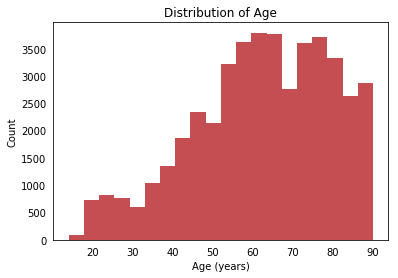

In [20]:
# Age is decode by finding the difference in admission date and date of birth
data['age'] = (data['ADMIT_MIN'] - data['DOB']).dt.days // 365
data['age'] = np.where(data['age'] < 0, 90, data['age'])
data['age'].isnull().sum()
data = data[data['age'] != 0]
# Note that no ‘middle’ patients show up - this reflects the fact that MIMIC-III does not contain data from pediatric patients.
plt.hist(data['age'], bins=20, color='#c44e52')
plt.ylabel('Count')
plt.xlabel('Age (years)')
plt.title('Distribution of Age')
plt.tick_params(left=False, bottom=False, top=False, right=False)
plt.show();

In [21]:
dum = data

In [22]:
#importing Notevents
df_notes = pd.read_sql("select * from NOTEEVENTS ", conn)
# look at the first note
df_notes.head()
df_notes.TEXT.iloc[0]
# filter to discharge summary
df_notes_dis_sum = df_notes.loc[df_notes.CATEGORY == 'Discharge summary']


df_notes_dis_sum_last = (df_notes_dis_sum.groupby(['SUBJECT_ID','HADM_ID']).nth(-1)).reset_index()
assert df_notes_dis_sum_last.duplicated(['HADM_ID']).sum() == 0, 'Multiple discharge summaries per admission'

df_adm_notes = pd.merge(dum,df_notes_dis_sum_last[['SUBJECT_ID','HADM_ID','TEXT']],on = ['SUBJECT_ID','HADM_ID'],how = 'left')


In [23]:
print('Fraction of missing notes:', df_adm_notes.TEXT.isnull().sum() / len(df_adm_notes))
print('Fraction notes with newlines:', df_adm_notes.TEXT.str.contains('\n').sum() / len(df_adm_notes))
print('Fraction notes with carriage returns:', df_adm_notes.TEXT.str.contains('\r').sum() / len(df_adm_notes))

Fraction of missing notes: 0.030504037625343865
Fraction notes with newlines: 0.9694959623746562
Fraction notes with carriage returns: 0.0


In [24]:
df_adm_notes_clean = df_adm_notes.loc[df_adm_notes.ADMISSION_TYPE != 'NEWBORN'].copy()
df_adm_notes_clean['OUTPUT_LABEL']=df_adm_notes_clean['Readmssion'].astype(int)

df_adm_notes_clean.to_csv('HapProjectCleaned.csv')

print('Number of positive samples:', (df_adm_notes_clean.OUTPUT_LABEL == 1).sum())
print('Number of negative samples:',  (df_adm_notes_clean.OUTPUT_LABEL == 0).sum())
print('Total samples:', len(df_adm_notes_clean))

Number of positive samples: 2958
Number of negative samples: 42118
Total samples: 45076


In [25]:
df = df_adm_notes_clean

In [26]:
import nltk
from nltk import word_tokenize
import string
import re
print(string.punctuation)

def preprocess_text(df):
    # This function preprocesses the text by filling not a number and replacing new lines ('\n') and carriage returns ('\r')
    df.TEXT = df.TEXT.fillna(' ')
    df.TEXT =df.TEXT.str.replace('\n',' ')
    df.TEXT =df.TEXT.str.replace('\r',' ')
    return df

df = preprocess_text(df)

stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()
wn = nltk.WordNetLemmatizer()

def clean_textmain(text):
    text = text.lower()
    text ="".join([char for char in text if char not in string.punctuation ])
    #text=re.sub(r'\b\w{1,4}\b', '',text)
    result = re.sub(r'[0-9]+','',text)
    tokens = re.split('\W+', result)
    words = [word for word in tokens if word.isalpha()]
    text1=[word for word in words if word not in string.digits]
    #text = [ps.stem(word) for word in text1 if word not in stopwords]
    text = [wn.lemmatize(word) for word in text1 if word not in stopwords]
    return text

from sklearn.feature_extraction.text import CountVectorizer
count_vect_sample = CountVectorizer(max_features = 3000,analyzer = clean_textmain)
X_counts_sample = count_vect_sample.fit_transform(df['TEXT'])
print(X_counts_sample.shape)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
(45076, 3000)


In [27]:
X_counts_df =pd.DataFrame(X_counts_sample.toarray())
#X_counts_df =pd.DataFrame(count_vect_sample.get_feature_names())
X_counts_df.columns = count_vect_sample.get_feature_names()
#print(X_counts_df.head())
#type(X_counts_df)
X_counts_df.head()

,aaa,aaox,ab,abd,abdomen,abdominal,abdpelvis,abg,ability,ablation,...,yeastnone,yellow,yesterday,yo,yr,zantac,zocor,zofran,zolpidem,zosyn
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,1,0,0,0,0,...,0,0,0,1,1,0,0,0,1,4
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [28]:
data = df.join(X_counts_df,lsuffix='_caller', rsuffix='_other')

data.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,ADMISSION_TYPE,ETHNICITY,DIAGNOSIS,Readmssion,blood_caller,circulatory,congenital,...,yeastnone,yellow,yesterday,yo,yr,zantac,zocor,zofran,zolpidem,zosyn
0,100,153952,2157-08-10 07:15:00,ELECTIVE,OTHER/UNKNOWN,AORTIC INSUFFICIENCY\AORTIC VALVE REPLACEMENT;...,0,0.0,4.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,10000,187813,2186-08-10 21:57:00,EMERGENCY,HISPANIC/LATINO,END STAGE LIVER DISEASE;END STAGE KIDNEY DISEASE,0,4.0,2.0,0.0,...,0,0,0,1,1,0,0,0,1,4
2,10003,144039,2111-11-21 23:47:00,EMERGENCY,BLACK/AFRICAN AMERICAN,HEMOTHORAX/RIB FX,0,1.0,2.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,10004,164713,2182-11-02 13:27:00,EMERGENCY,WHITE,S/P FALL;ICH,0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,10004,161106,2183-05-04 22:40:00,EMERGENCY,WHITE,"SUBDURAL HEMATOMA,SEIZURE,C3 FRACTURE",0,0.0,1.0,0.0,...,0,0,0,1,0,0,0,0,0,0


In [29]:
data.drop(columns=['SUBJECT_ID', 'HADM_ID', 'ADMITTIME' ,'ADMISSION_TYPE','Readmssion','ADMIT_MIN', 'DOB','DIAGNOSIS'], inplace=True)

df= data
df.columns
df = pd.get_dummies(data=df, columns=['ETHNICITY', 'GENDER'])
df = df.dropna()

In [30]:
count_classes = pd.value_counts(df['OUTPUT_LABEL'], sort = True)
count_classes

0    42102
1     2957
Name: OUTPUT_LABEL, dtype: int64

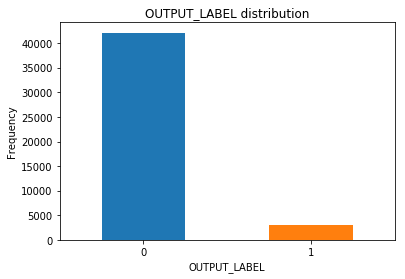

In [31]:
Labels = ["No readmission", "Readmission <30"]
plt.title("OUTPUT_LABEL distribution")
plt.xticks(range(2), Labels)
plt.xlabel("OUTPUT_LABEL")
plt.ylabel("Frequency")
count_classes.plot(kind = 'bar', rot=0)

In [32]:
print('Readmission after 30 Days', round(data['OUTPUT_LABEL'].value_counts()[0]/len(df) * 100,3), '% of the dataset')
print('Readmssion with in 30 Days', round(data['OUTPUT_LABEL'].value_counts()[1]/len(df) * 100,3), '% of the dataset')

Readmission after 30 Days 93.473 % of the dataset
Readmssion with in 30 Days 6.565 % of the dataset


In [33]:
import matplotlib.pyplot as plt # to plot graph
import seaborn as sns # for intractve graphs
import numpy as np # for linear algebra
import datetime # to dela with date and time
%matplotlib inline
from sklearn.preprocessing import StandardScaler # for preprocessing the data
from sklearn.ensemble import RandomForestClassifier # Random forest classifier
from sklearn.tree import DecisionTreeClassifier # for Decision Tree classifier
from sklearn.svm import SVC # for SVM classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection  import train_test_split # to split the data
from sklearn.model_selection  import KFold # For cross vbalidation
from sklearn.model_selection  import GridSearchCV # for tunnig hyper parameter it will use all combination of given parameters
from sklearn.model_selection import RandomizedSearchCV # same for tunning hyper parameter but will use random combinations of parameters
from sklearn.metrics import confusion_matrix,recall_score,precision_recall_curve,auc,roc_curve,roc_auc_score,classification_report
import warnings
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
warnings.filterwarnings('ignore')
data = df
data.head()

,blood_caller,circulatory,congenital,digestive,endocrine_caller,genitourinary,infectious_caller,injury_caller,mental_caller,misc,...,zofran,zolpidem,zosyn,ETHNICITY_ASIAN,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_HISPANIC/LATINO,ETHNICITY_OTHER/UNKNOWN,ETHNICITY_WHITE,GENDER_F,GENDER_M
0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,1,0,1,0
1,4.0,2.0,0.0,5.0,2.0,2.0,1.0,1.0,1.0,2.0,...,0,1,4,0,0,1,0,0,0,1
2,1.0,2.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,1
3,0.0,1.0,0.0,1.0,2.0,1.0,0.0,3.0,0.0,1.0,...,0,0,0,0,0,0,0,1,0,1
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,1


In [34]:
#data.drop(columns=['Unnamed: 0','Unnamed: 0.1'], inplace=True)
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df = data.select_dtypes(include=numerics)
cols=list(df.columns)
cols.remove('OUTPUT_LABEL')
df.shape

(45059, 3019)

# Under sampling

In [35]:
# shuffle the samples
df = df.sample(n = len(df), random_state = 42)
df = df.reset_index(drop = True)

# Save 30% of the data as validation and test data
df_test=df.sample(frac=0.20,random_state=42)

# use the rest of the data as training data
df_train_all=df.drop(df_test.index)

print('Test prevalence(n = %d):'%len(df_test),df_test.OUTPUT_LABEL.sum()/ len(df_test))
print('Train all prevalence(n = %d):'%len(df_train_all), df_train_all.OUTPUT_LABEL.sum()/ len(df_train_all))
print('all samples (n = %d)'%len(df))

Test prevalence(n = 9012): 0.06624500665778961
Train all prevalence(n = 36047): 0.06547008072793853
all samples (n = 45059)


In [36]:
# split the training data into positive and negative
rows_pos = df_train_all.OUTPUT_LABEL == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

# merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)],axis = 0)

In [37]:
# shuffle the order of training samples
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)
print('Train prevalence (n = %d):'%len(df_train), df_train.OUTPUT_LABEL.sum()/ len(df_train))

Train prevalence (n = 4720): 0.5


In [38]:
X_train_tf = df_train[cols].values
X_test_tf = df_test[cols].values
y_train = df_train.OUTPUT_LABEL
y_test = df_test.OUTPUT_LABEL

In [39]:
#Randomforest
clf=RandomForestClassifier(n_estimators=300)
clf.fit(X_train_tf, y_train)

model = clf
y_train_preds = model.predict_proba(X_train_tf)[:,1]
y_test_preds = model.predict_proba(X_test_tf)[:,1]
print(y_train[:10].values)
print(y_train_preds[:10])

[0 1 1 1 0 1 1 0 1 1]
[0.20666667 0.86666667 0.78333333 0.86666667 0.07       0.86333333
 0.90666667 0.18       0.74       0.81333333]


In [40]:
def calc_accuracy(y_actual, y_pred, thresh):
    # this function calculates the accuracy with probability threshold at thresh
    return (sum((y_pred > thresh) & (y_actual == 1))+sum((y_pred < thresh) & (y_actual == 0))) /len(y_actual)

def calc_recall(y_actual, y_pred, thresh):
    # calculates the recall
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_actual)

def calc_precision(y_actual, y_pred, thresh):
    # calculates the precision
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_pred > thresh)

def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y_actual):
    # calculates prevalence
    return sum((y_actual == 1)) /len(y_actual)

In [41]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
fpr_test, tpr_test, thresholds_tets = roc_curve(y_test, y_test_preds)


thresh = 0.5

auc_train = roc_auc_score(y_train, y_train_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

print('Train AUC:%.3f'%auc_train)
print('Test AUC:%.3f'%auc_test)

print('Train accuracy:%.3f'%calc_accuracy(y_train, y_train_preds, thresh))
print('Test accuracy:%.3f'%calc_accuracy(y_test, y_test_preds, thresh))


print('Train recall:%.3f'%calc_recall(y_train, y_train_preds, thresh))
print('Test recall:%.3f'%calc_recall(y_test,y_test_preds, thresh))

print('Train precision:%.3f'%calc_precision(y_train, y_train_preds, thresh))
print('Test precision:%.3f'%calc_precision(y_test, y_test_preds, thresh))

print('Train specificity:%.3f'%calc_specificity(y_train, y_train_preds, thresh))
print('Test specificity:%.3f'%calc_specificity(y_test, y_test_preds, thresh))

print('Train prevalence:%.3f'%calc_prevalence(y_train))
print('Test prevalence:%.3f'%calc_prevalence(y_test))

Train AUC:1.000
Test AUC:0.695
Train accuracy:1.000
Test accuracy:0.587
Train recall:1.000
Test recall:0.685
Train precision:1.000
Test precision:0.106
Train specificity:1.000
Test specificity:0.580
Train prevalence:0.500
Test prevalence:0.066


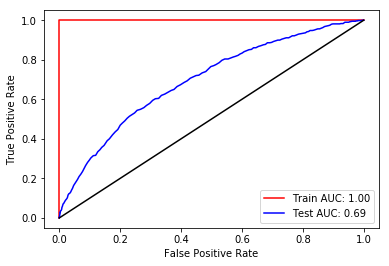

In [42]:
plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_test, tpr_test,'b-',label = 'Test AUC: %.2f'%auc_test)
plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

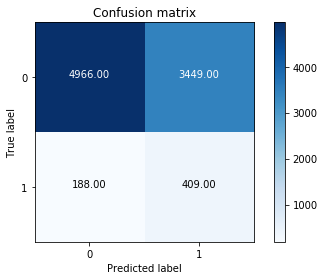

In [43]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


cnf_matrix=confusion_matrix(y_test,y_test_preds.round())
plot_confusion_matrix(cnf_matrix,classes=[0,1])
plt.show()

In [44]:
rf = RandomForestClassifier()
rf.fit(X_train_tf, y_train)
probs_rf = rf.predict_proba(X_test_tf)
res = pd.DataFrame()
res['Output_label'] = y_test
res['rf'] = probs_rf[:,1]
res.head(10)

,Output_label,rf
1232,0,0.5
24177,1,0.7
31534,0,0.4
34035,0,0.3
17963,0,0.7
40499,0,0.5
36475,0,0.4
33321,0,0.3
45052,0,0.4
31780,0,0.3


In [45]:
fpr_rf, tpr_rf, threshold_rf = roc_curve(res['Output_label'] , res['rf'])
auc_rf = auc(fpr_rf ,tpr_rf)
print(auc_rf)

0.6233749456332963


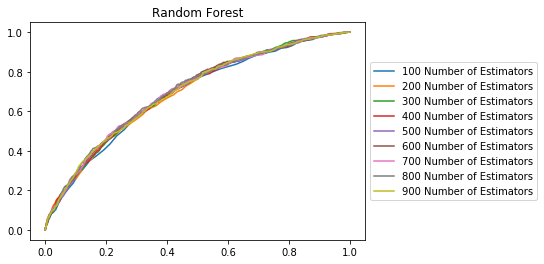

In [46]:
rf = dict()
probs_rf = dict()
fpr_rf = dict()
tpr_rf = dict()
thresholds_rf = dict()
auc_rf = dict()
Auc =[]
Number_of_Estimators =[]
for n in range(100, 1000, 100):
    rf[n]=RandomForestClassifier(n_estimators =n)
    rf[n].fit(X_train_tf, y_train)
    probs_rf[n]=rf[n].predict_proba(X_test_tf)
    fpr_rf[n], tpr_rf[n], thresholds_rf[n] = roc_curve(y_test,probs_rf[n][:,1])
    auc_rf[n]=auc(fpr_rf[n],tpr_rf[n])
    Auc.append(auc_rf[n])
    Number_of_Estimators.append(n)
    plt.title('Random Forest')
    plt.plot(fpr_rf[n], tpr_rf[n],label = "{} Number of Estimators".format(n))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

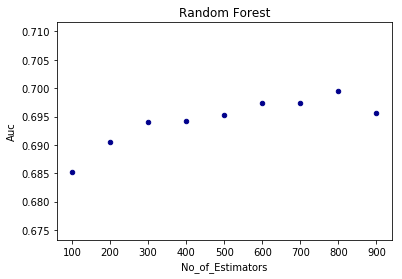

In [47]:
aucperf= pd.DataFrame({'No_of_Estimators':Number_of_Estimators,'Auc':Auc})
aucperf.plot.scatter(x='No_of_Estimators',y='Auc',c='DarkBlue',title = 'Random Forest')

#  Feature Selection

In [49]:
mic = mutual_info_classif(X_train_tf, y_train)
mic
s = pd.DataFrame()
s['att'] = cols
s['mic'] = mic
chi2 = chi2(X_train_tf, y_train)
s['chi2'] = chi2[0]

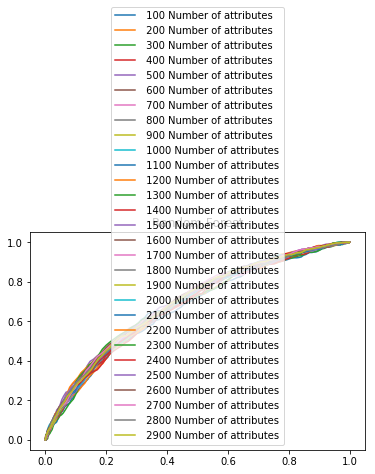

In [50]:
rf200=RandomForestClassifier(n_estimators=200)
Auc =[]
No_of_Attributes =[]
for n in range(100, 3000, 100):
    cols_sel_mic=s.sort_values('mic', ascending=False)['att'][:n]
    rf200.fit(df_train[cols_sel_mic],df_train['OUTPUT_LABEL'])
    probs_rf200=rf200.predict_proba(df_test[cols_sel_mic])
    fpr_rf200, tpr_rf200, thresholds_rf200 = roc_curve(df_test['OUTPUT_LABEL'],probs_rf200[:,1])
    auc_rf200=auc(fpr_rf200,tpr_rf200)
    Auc.append(auc_rf200)
    No_of_Attributes.append(n)
    plt.title('Random Forest')
    plt.plot(fpr_rf200, tpr_rf200,label =" {} Number of attributes".format(n))
    plt.legend(loc='Right')

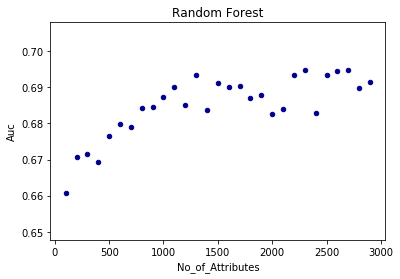

In [51]:
aucperf= pd.DataFrame({'No_of_Attributes':No_of_Attributes,'Auc':Auc})
aucperf.plot.scatter(x='No_of_Attributes',y='Auc',c='DarkBlue',title = 'Random Forest')

# Over Sampling

In [52]:
df_test.shape
df_train_all.shape

X_train = df_train_all[cols].values
y_train = df_train_all.OUTPUT_LABEL

In [53]:
os =  RandomOverSampler(ratio=1)
X_train_res, y_train_res = os.fit_sample(X_train, y_train)

print ("Distribution of class labels before resampling {}".format(Counter(y_train)))
print ("Distribution of class labels after resampling {}".format(Counter(y_train_res)))

Distribution of class labels before resampling Counter({0: 33687, 1: 2360})
Distribution of class labels after resampling Counter({0: 33687, 1: 33687})


In [54]:
X_test_tf.shape
y_test.shape

(9012,)

In [57]:
clf=RandomForestClassifier(n_estimators=300)
clf.fit(X_train_res, y_train_res)

model = clf
y_train_preds = model.predict_proba(X_train_res)[:,1]
y_test_preds = model.predict_proba(X_test_tf)[:,1]

Train AUC:1.000
Test AUC:0.701
Train accuracy:1.000
Test accuracy:0.934
Train recall:1.000
Test recall:0.003
Train precision:1.000
Test precision:0.500
Train specificity:1.000
Test specificity:1.000
Train prevalence:0.500
Test prevalence:0.066


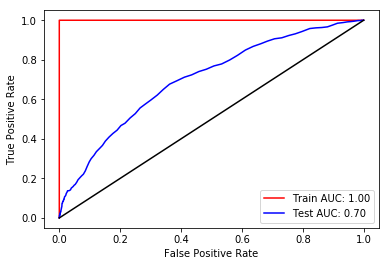

In [58]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_res, y_train_preds)
fpr_test, tpr_test, thresholds_tets = roc_curve(y_test, y_test_preds)


thresh = 0.5

auc_train = roc_auc_score(y_train_res, y_train_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

print('Train AUC:%.3f'%auc_train)
print('Test AUC:%.3f'%auc_test)

print('Train accuracy:%.3f'%calc_accuracy(y_train_res, y_train_preds, thresh))
print('Test accuracy:%.3f'%calc_accuracy(y_test, y_test_preds, thresh))


print('Train recall:%.3f'%calc_recall(y_train_res, y_train_preds, thresh))
print('Test recall:%.3f'%calc_recall(y_test,y_test_preds, thresh))

print('Train precision:%.3f'%calc_precision(y_train_res, y_train_preds, thresh))
print('Test precision:%.3f'%calc_precision(y_test, y_test_preds, thresh))

print('Train specificity:%.3f'%calc_specificity(y_train_res, y_train_preds, thresh))
print('Test specificity:%.3f'%calc_specificity(y_test, y_test_preds, thresh))

print('Train prevalence:%.3f'%calc_prevalence(y_train_res))
print('Test prevalence:%.3f'%calc_prevalence(y_test))


plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_test, tpr_test,'b-',label = 'Test AUC: %.2f'%auc_test)
plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

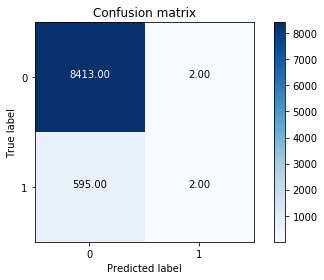

In [59]:
cnf_matrix=confusion_matrix(y_test,y_test_preds.round())
plot_confusion_matrix(cnf_matrix,classes=[0,1])
plt.show()

# Over Sampling And Undersampling 

In [60]:
X_test1=df_test[cols]
X_train1=df_train_all[cols]
y_test1=df_test.OUTPUT_LABEL
y_train1=df_train_all.OUTPUT_LABEL

In [61]:
from sklearn.metrics import recall_score,accuracy_score,confusion_matrix, f1_score, precision_score, auc,roc_auc_score,roc_curve, precision_recall_curve
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import ClusterCentroids,NearMiss, RandomUnderSampler
from imblearn.combine import SMOTEENN,SMOTETomek
from imblearn.ensemble import BalanceCascade
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection  import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [62]:
print(X_test1.shape)
print(y_test1.shape)
print(X_train1.shape)
print(y_train1.shape)

(9012, 3018)
(9012,)
(36047, 3018)
(36047,)


In [64]:
def benchmark(sampling_type,X,y):
    lr = LogisticRegression(penalty = 'l1')
    param_grid = {'C':[0.01,0.1,1,10]}
    gs = GridSearchCV(estimator=lr, param_grid=param_grid, scoring='accuracy', cv=5, verbose=2)
    gs = gs.fit(X,y)
    return sampling_type,gs.best_score_,gs.best_params_['C']

def transform(transformer,X,y):
    print("Transforming {}".format(transformer.__class__.__name__))
    X_resampled,y_resampled = transformer.fit_sample(X,y)
    return transformer.__class__.__name__,pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)

In [65]:
datasets = []
datasets.append(("base",X_train1,y_train1))
datasets.append(transform(SMOTE(n_jobs=-1),X_train1,y_train1))
datasets.append(transform(RandomOverSampler(),X_train1,y_train1))
datasets.append(transform(NearMiss(n_jobs=-1),X_train1,y_train1))
datasets.append(transform(RandomUnderSampler(),X_train1,y_train1))

Transforming SMOTE
Transforming RandomOverSampler
Transforming NearMiss
Transforming RandomUnderSampler


In [66]:
benchmark_scores = []
for sample_type,X,y in datasets:
    print('______________________________________________________________')
    print('{}'.format(sample_type))
    benchmark_scores.append(benchmark(sample_type,X,y))
    print('______________________________________________________________')

______________________________________________________________
base
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................................... C=0.01, total=   4.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s


[CV] ........................................... C=0.01, total=   3.9s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   3.8s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   3.7s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   3.6s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=  11.0s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=  11.1s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=  11.8s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  6.0min finished


______________________________________________________________
______________________________________________________________
SMOTE
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................................... C=0.01, total=  15.5s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.1s remaining:    0.0s


[CV] ........................................... C=0.01, total=  14.1s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   9.7s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=  13.8s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   9.2s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=  59.1s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=  47.0s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=  36.4s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 20.1min finished


______________________________________________________________
______________________________________________________________
RandomOverSampler
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................................... C=0.01, total=  15.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.5s remaining:    0.0s


[CV] ........................................... C=0.01, total=  11.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=  15.3s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=  11.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=  10.5s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=  31.8s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=  38.7s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total= 1.2min
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 17.0min finished


______________________________________________________________
______________________________________________________________
NearMiss
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................................... C=0.01, total=   0.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ........................................... C=0.01, total=   0.1s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.1s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.1s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................................... C=0.01, total=   0.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ........................................... C=0.01, total=   0.2s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.1s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.2s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.5s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.4s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   32.2s finished


______________________________________________________________


In [68]:
scores = []
# train models based on benchmark params
for sampling_type,score,param in benchmark_scores:
    print("Training on {}".format(sampling_type))
    lr = LogisticRegression(penalty = 'l1',C=param)
    for s_type,X,y in datasets:
        if s_type == sampling_type:
            lr.fit(X,y)
            pred_test = lr.predict(X_test_tf)
            pred_test_probs = lr.predict_proba(X_test_tf)
            probs = lr.decision_function(X_test_tf)
            fpr, tpr, thresholds = roc_curve(y_test.values.ravel(),pred_test)
            p,r,t = precision_recall_curve(y_test.values.ravel(),probs)
            scores.append((sampling_type,
                           f1_score(y_test.values.ravel(),pred_test),
                           precision_score(y_test.values.ravel(),pred_test),
                           recall_score(y_test.values.ravel(),pred_test),
                           accuracy_score(y_test.values.ravel(),pred_test),
                           auc(fpr, tpr),
                           auc(p,r,reorder=True),
                           confusion_matrix(y_test.values.ravel(),pred_test)))

Training on base
Training on SMOTE
Training on RandomOverSampler
Training on NearMiss
Training on RandomUnderSampler


In [69]:
sampling_results = pd.DataFrame(scores,columns=['Sampling Type','f1','precision','recall','accuracy','auc_roc','auc_pr','confusion_matrix'])
sampling_results

,Sampling Type,f1,precision,recall,accuracy,auc_roc,auc_pr,confusion_matrix
0,base,0.003317,0.166667,0.001675,0.933311,0.500540,0.099601,"[[8410, 5], [596, 1]]"
1,SMOTE,0.169247,0.107798,0.393635,0.744008,0.581250,0.080212,"[[6470, 1945], [362, 235]]"
2,RandomOverSampler,0.175082,0.111781,0.403685,0.748003,0.588058,0.041618,"[[6500, 1915], [356, 241]]"
3,NearMiss,0.126126,0.067608,0.938023,0.138926,0.510129,0.064016,"[[692, 7723], [37, 560]]"
4,RandomUnderSampler,0.199711,0.120642,0.579564,0.692299,0.639931,0.093884,"[[5893, 2522], [251, 346]]"
